# CoordConv Baseline Application: Classification of Pneumonia in Chest Radiographs 

**Team: Connor Davis, Viggy Kumaresan, and Danny Witt**

**References:**

* Data: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 

* Data Preprocessing: https://www.kaggle.com/paultimothymooney/predicting-pathologies-in-x-ray-images

In [22]:
import os
from tqdm import tqdm
from pkgutil import get_data
from glob import glob
import pandas as pd
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
import random
import numpy as np
import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from skimage import data, io, filters, transform

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical


In [16]:
!pwd

/Users/dannywitt/Desktop/MIDS/MIDS_YR2/BME_590_DL_Tensorflow/Project_2_CoordConv


In [20]:
local_path = '/Users/dannywitt/Desktop/MIDS/MIDS_YR2/BME_590_DL_Tensorflow/Project_2_CoordConv/'

In [23]:
train_dir = local_path + "chest_xray/train/"
test_dir =  local_path + "chest_xray/test/"
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

100%|██████████| 234/234 [02:08<00:00,  1.68it/s]
Using TensorFlow backend.


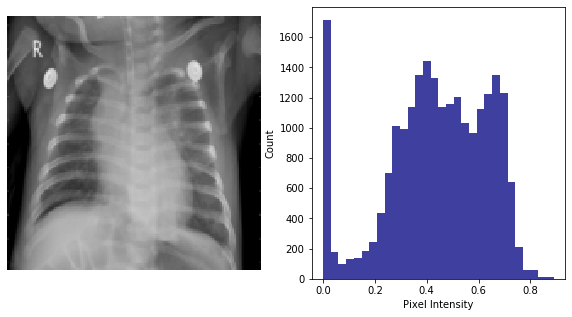

In [24]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

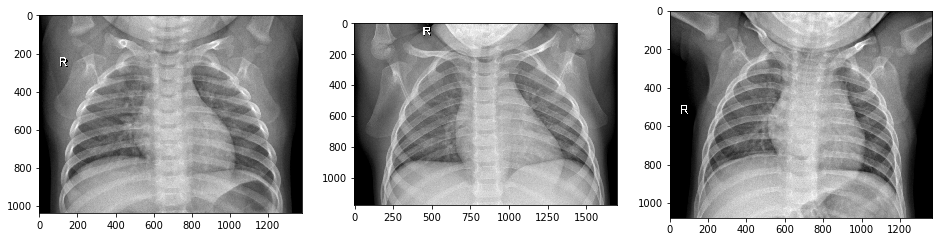

In [26]:
multipleImages = glob(local_path+'chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

No Pneumonia


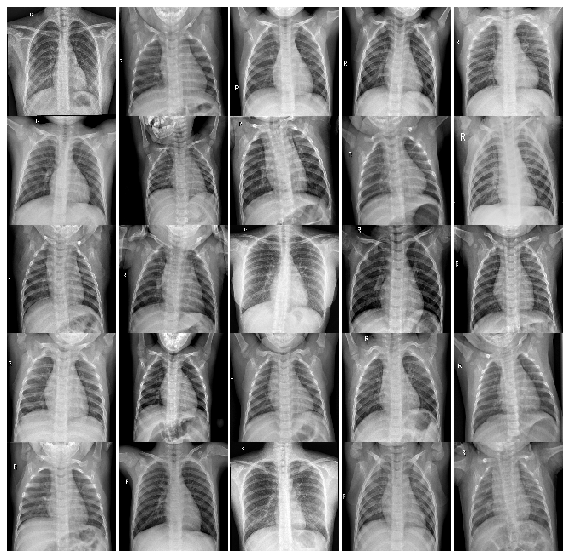

In [28]:
print("No Pneumonia")
multipleImages = glob(local_path + 'chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Yes Pneumonia


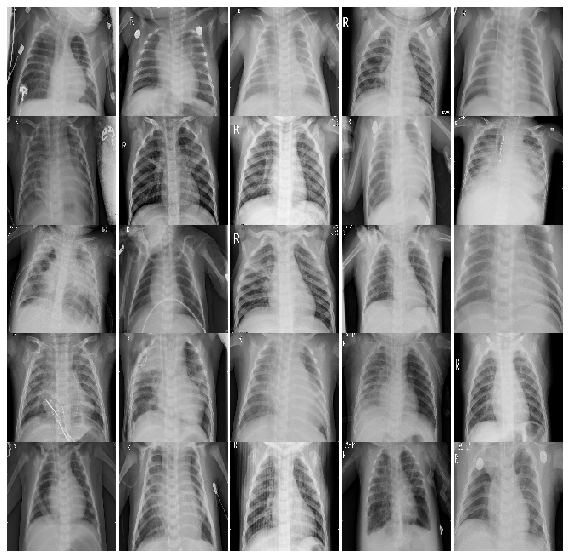

In [29]:
print("Yes Pneumonia")
multipleImages = glob(local_path + 'chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


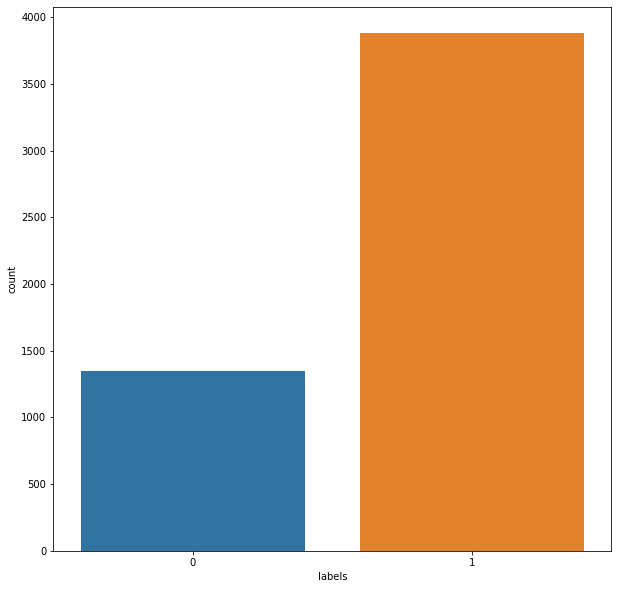

In [30]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [31]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


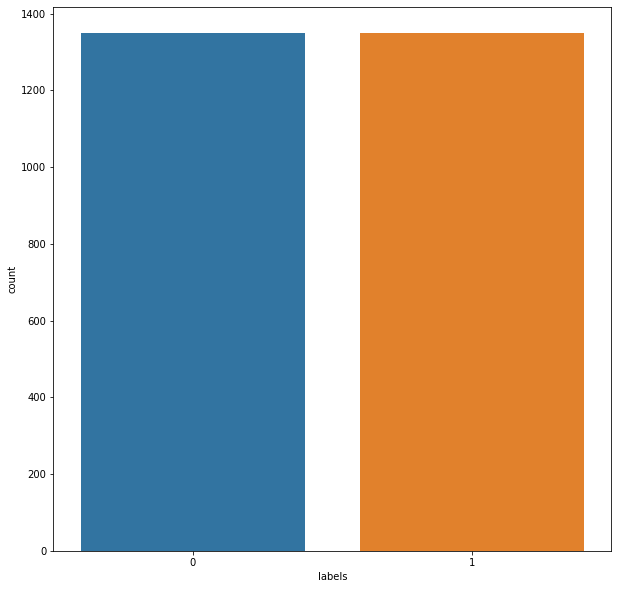

In [33]:
from imblearn.under_sampling import RandomUnderSampler
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 150,150,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = 150,150,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [34]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.93921423 0.6737059 ]
New Class Weights:  [1. 1.]


In [ ]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adagrad
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, Callback

def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
    
runCNNconfusion(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,8,6,1)

In [39]:
#Baseline CNN Model:

from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adagrad
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, Callback
import sklearn
from sklearn.metrics import confusion_matrix

map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
optimizer1 = keras.optimizers.RMSprop(lr=0.001)

def CNN(xtrain, ytrain, xtest, ytest, classweight, numclasses, numepochs, labels):
    
    #Define Model:
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    
    #Define hyperparameters:
    batch_size = 128
    num_classes = numclasses
    epochs = numepochs
    
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (150, 150, 3)
    
    #Model Architecture:
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 150, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 150, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    
    # Define the optimizer:
    optimizer = Adagrad()
    
    #Compile Model and Prepare Metrics/Visualizations:
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

CNN(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, class_weight1, 2, 5, map_characters1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 150)       43350     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 150)       202650    
__________

KeyboardInterrupt: 

In [ ]:
# CoordConv Layer Implementation:

class CoordConv2D(Layer):
    def __init__(self, channel, kernel, padding='valid', **kwargs):
        self.layer = Conv2D(channel, kernel, padding=padding)
        self.name = 'CoordConv2D'
        super(CoordConv2D, self).__init__(**kwargs)

    def call(self, input):
        input_shape = tf.unstack(K.shape(input))
        if K.image_data_format() == 'channel_first':
            bs, channel, w, h = input_shape
        else:
            bs, w, h, channel = input_shape

        # Get indices
        indices = tf.to_float(tf.where(K.ones([bs, w, h])))
        canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]
        
        # Normalize 
        canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
        canvas = (canvas * 2) - 1

        # Concatenate channel-wise
        input = K.concatenate([input, canvas], -1)
        return self.layer(input)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

In [ ]:
# CNN + CoordConv Model:

map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
optimizer1 = keras.optimizers.RMSprop(lr=0.0001)

def CoordConv_CNN(xtrain, ytrain, xtest, ytest, classweight, numclasses, numepochs, labels):
    
    #Define Model:
    # In -> [CoordConv2D] -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    
    #Define hyperparameters:
    batch_size = 128
    num_classes = numclasses
    epochs = numepochs
    
    input_shape = (150, 150, 3)
    
    #Model Architecture:
    model = Sequential()
    model.add(CoordConv2D(filters = 32, kernel_size = (3,3),padding = 'Same'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 150, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 150, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    
    # Define the optimizer:
    optimizer = Adagrad()
    
    # Compile Model and Prepare Metrics/Visualizations:
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

CoordConv_CNN(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, class_weight1, 2, 3, map_characters1)